In [7]:
# get datasetd from "geometry of truth paper"
!git clone https://github.com/saprmarks/geometry-of-truth.git /root/geometry-of-truth
!mv /root/geometry-of-truth/datasets/*.csv data

fatal: destination path '/root/geometry-of-truth' already exists and is not an empty directory.
mv: cannot stat '/root/geometry-of-truth/datasets/*.csv': No such file or directory


In [1]:
import os
import pandas as pd
from transformers import AutoTokenizer, AutoModelForCausalLM
from baukit import Trace
import torch
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np

In [185]:
# import my modules
import importlib
# join the path to the modules to the current working directory
import utils, dataset_utils
importlib.reload(utils)
importlib.reload(dataset_utils)
from utils import *
from dataset_utils import *

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
precision = torch.float16
# load model
# model_name = "mistralai/Mistral-7B-v0.1"
model_name = "HuggingFaceH4/zephyr-7b-beta" 
#model_name = "meta-llama/Llama-2-7b-chat-hf"
short_model_name = model_name.split("/")[-1]
plots_folder = f'plots/{short_model_name}'
os.makedirs(plots_folder, exist_ok=True)
# model_name = "huggyllama/llama-7b"
# load tokenizer
if model_name == "meta-llama/Llama-2-7b-chat-hf":
    # get access token from environment variable
    access_token = os.getenv("HF_TOKEN")
    if not access_token:
        access_token = input("Please set the HF_TOKEN environment variable to your Hugging Face access token.")
    # access_token = input("Enter your access token: ")
    model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=precision, token=access_token).to(device).eval()
    tokenizer = AutoTokenizer.from_pretrained(model_name, token=access_token)
    tokenizer.padding_side = "left"
    tokenizer.pad_token_id = tokenizer.eos_token_id

else:

    model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16).to(device).eval()
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    tokenizer.padding_side = "left"
    tokenizer.pad_token_id = tokenizer.eos_token_id


batch_size = 64
module_names = [f'model.layers.{i}' for i in range(model.config.num_hidden_layers)]
num_modules = len(module_names)

In [182]:
# iterate through all csv files in data folder
for file in os.listdir('data'):
    if not file.endswith('.csv'):
        continue
    df = pd.read_csv('data/'+file)
    print('\n','#'*10, file, '#'*10)
    # print column names
    print(df.columns)


 ########## cities.csv ##########
Index(['statement', 'label', 'city', 'country', 'correct_country'], dtype='object')

 ########## cities_cities_conj.csv ##########
Index(['statement', 'label', 'statement1', 'label1', 'city1', 'country1',
       'correct_country1', 'statement2', 'label2', 'city2', 'country2',
       'correct_country2'],
      dtype='object')

 ########## cities_cities_disj.csv ##########
Index(['statement', 'label', 'statement1', 'label1', 'city1', 'country1',
       'correct_country1', 'statement2', 'label2', 'city2', 'country2',
       'correct_country2'],
      dtype='object')

 ########## common_claim.csv ##########
Index(['Unnamed: 0', 'examples', 'label', 'agreement'], dtype='object')

 ########## common_claim_true_false.csv ##########
Index(['statement', 'label'], dtype='object')

 ########## companies_true_false.csv ##########
Index(['statement', 'label'], dtype='object')

 ########## counterfact_true_false.csv ##########
Index(['statement', 'label', 'relation

In [186]:
train_dataset = load_csv_dataset(dataset_name = 'instructions')

token_positions = -1
# returns a dictionary with the hidden states of token_position (shape [len(selected_data), hidden_dim]) for each module
train_dataset['hidden_states'] = get_hidden(model, tokenizer, module_names, train_dataset['org_data'], batch_size=batch_size, token_position=-1)

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:01<00:00,  1.84it/s]


In [187]:
train_dataset['hidden_states'].shape

torch.Size([32, 110, 4096])

In [188]:
train_data, test_data, train_labels, test_labels = prep_data(train_dataset['hidden_states'], train_dataset['label'], train_perc=1.0)
train_data.shape, test_data.shape

(torch.Size([32, 110, 4096]), torch.Size([32, 0, 4096]))

In [189]:
# training probes
probe_type = 'MassMean' # 'LR'

probes = {}
for idx, module in tqdm(enumerate(module_names), total=num_modules):
    if probe_type == 'MassMean':
        probes[module] = MassMeanProbe()
        probes[module].train(train_data[idx], train_labels)
    elif probe_type == 'LR':
        probes[module] = LRProbe(d_in=model.config.hidden_size, device='cuda', dtype=torch.float32)
        probes[module].train(train_data[idx], train_labels, epochs=2, batch_size=batch_size)

# test on same dataset
test_accs = {}
train_accs = {}
for idx, module in enumerate(module_names):
    test_accs[module] = probes[module].test(test_data[idx], test_labels)
    train_accs[module] = probes[module].test(train_data[idx], train_labels)

100%|██████████| 32/32 [00:00<00:00, 1654.15it/s]


AttributeError: 'int' object has no attribute 'item'

In [167]:
# print every 5th test acc:
for index, (key, value) in enumerate(test_accs.items()):
    if index % 5 == 0:
        print(f'{key}\t{value:.2g}') 

model.layers.0	0.57
model.layers.5	0.69
model.layers.10	0.75
model.layers.15	0.76
model.layers.20	0.75
model.layers.25	0.74
model.layers.30	0.73


In [190]:
# test on out of distribution dataset

test_dataset_name = 'Statements1000' #  Statements1000, FreebaseStatements, Burglar
max_new_tokens = 20 if test_dataset_name == 'Burglar' else 10

# load dataset
test_dataset = load_data_set(test_dataset_name)
if model_name == "meta-llama/Llama-2-7b-chat-hf":
    lie_format = "[INST]You will complete the sentence with intentionally false information. [/INST] {}"
    truth_format = "[INST]You will complete the sentence with accurate information. [/INST] {}"
    change_format(test_dataset, lie_format, truth_format)

print('\nGenerating truths and lies')
get_overlap_truth_lies(model, tokenizer, test_dataset, max_new_tokens=max_new_tokens, batch_size=batch_size)
# get hidden states for the new dataset



Generating truths and lies
Size of dataset Statements1000: 1012


  7%|▋         | 1/15 [00:00<00:13,  1.02it/s]

16it [00:15,  1.01it/s]                        
16it [00:00, 1012.67it/s]             


Success rate when generating truths: 74.90%


16it [00:16,  1.02s/it]                        
16it [00:00, 1020.00it/s]             

Success rate when generating lies:   62.35%
Overlap: 42.29%


# evolution of acc over all tokens

In [191]:
attention_mask_lie = test_dataset['output_tokens_lie']['attention_mask']
attention_mask_truth = test_dataset['output_tokens_truth']['attention_mask']

max_num_tokens_lie = attention_mask_lie.shape[1]
max_num_tokens_truth = attention_mask_truth.shape[1]
num_samples = attention_mask_lie.shape[0]
hidden_dim = model.config.hidden_size
max_num_tokens_lie, max_num_tokens_truth


(62, 60)

In [192]:
attention_mask_lie.shape

torch.Size([428, 62])

In [193]:
max_tokens = max(max_num_tokens_lie, max_num_tokens_truth)
start_lie = max_tokens - max_num_tokens_lie
start_truth = max_tokens - max_num_tokens_truth

# the hidden states are quite large, so we need to split them into smaller batches
half_batch_size = 16

In [194]:
max_tokens

62

In [195]:
print('\nCalculating hidden states')
# returns a dictionary with the hidden states of token_position (shape [len(selected_data), hidden_dim]) for each module
normalize = True
# i iterate from the back as i use left padding and tokens of lying and truth telling are aligned at the end
probe_output = torch.zeros([num_modules, num_samples*2, max_tokens], device='cpu', dtype=torch.float32)*torch.Tensor([float('nan')])
test_accs = torch.zeros([num_modules, num_samples*2, max_tokens], device='cpu', dtype=torch.float32)*torch.Tensor([float('nan')])
for i, j in zip(range(0, num_samples, half_batch_size), range(0, 2*num_samples, 2*half_batch_size)):


    this_batch_size = min(half_batch_size, num_samples-i)

    # indices for combined batch
    start_full = j
    end_full = j+this_batch_size*2

    hidden_states = torch.zeros([num_modules, this_batch_size*2, max_tokens, hidden_dim], device='cpu', dtype=precision)
    attention_mask = torch.zeros([this_batch_size*2, max_tokens], device='cpu', dtype=attention_mask_lie.dtype)

    token_positions_lie = range(max_num_tokens_lie)
    data = {'input_ids': test_dataset['output_tokens_lie']['input_ids'][i:i+this_batch_size],
            'attention_mask': test_dataset['output_tokens_lie']['attention_mask'][i:i+this_batch_size]}
    temp_hidden = get_hidden_from_tokens(model, module_names, data, batch_size=batch_size, token_position=token_positions_lie)
    attention_mask[:this_batch_size, start_lie:max_tokens] = data['attention_mask']

    # set values where attention is zero to nan
    hidden_states[:, :this_batch_size, start_lie:max_tokens, :] = temp_hidden

    token_positions_truth = range(max_num_tokens_truth)
    data = {'input_ids': test_dataset['output_tokens_truth']['input_ids'][i:i+this_batch_size],
            'attention_mask': test_dataset['output_tokens_truth']['attention_mask'][i:i+this_batch_size]}
    temp_hidden = get_hidden_from_tokens(model, module_names, data, batch_size=batch_size, token_position=token_positions_truth)
    temp_attention = (attention_mask_truth[i:i+this_batch_size, :][None, :, :, None]==1)
    hidden_states[:, this_batch_size:, start_truth:max_tokens, :] = temp_hidden
    attention_mask[this_batch_size:, start_truth:max_tokens] = data['attention_mask']
    test_labels = torch.cat([torch.zeros(this_batch_size), torch.ones(this_batch_size)])
    
    # just average over padding tokens
    # attention_mask = torch.ones([this_batch_size*2, max_tokens], device='cpu', dtype=attention_mask_lie.dtype)


    if normalize:
        # TODO!!!
        # I should still somehow normalize
        # there are a lot of repeated tokens in the beginning 
        # (like all the instructions are exactly the same, if i take the mean over all the tokens, it is going to be heavily biased)
        # calc statistics over samples and token positions
        # calc mean over hidden states only for values where attention is not zero
        temp_hidden = torch.where(condition=attention_mask[None, :, :, None]==1, input=hidden_states, other=torch.Tensor([float('nan')]))
        # mean_test = temp_hidden.nanmean([1, 2], keepdim=True)
        # std_test = temp_hidden.nanmean([1, 2], keepdim=True)
        # hidden_states = (hidden_states - mean_test)/std_test

    for idx, module in tqdm(enumerate(module_names), total=len(module_names)):
        probe = probes[module]
        for token_pos in range(hidden_states.shape[2]):
            with torch.no_grad():
                acts_batch = hidden_states[idx, :, token_pos].to(device=probe.device, dtype=probe.dtype)
                probe_output[idx, start_full:end_full, token_pos] = probe.forward(acts_batch).detach().cpu()

    test_accs[:, start_full:end_full, :] = (probe_output[:, start_full:end_full, :]>0.5)==test_labels[None, :, None]

    # set accs to nan where attention is zero
    test_accs[:, start_full:end_full, :] = torch.where(condition=attention_mask[None, :, :]==1,
                                                         input=test_accs[:, start_full:end_full, :],
                                                            other=torch.Tensor([float('nan')]))
                                                         
    probe_output[:, start_full:end_full, :] = torch.where(condition=attention_mask[None, :, :]==1, 
                                                                input=probe_output[:, start_full:end_full, :], 
                                                                other=torch.Tensor([float('nan')]))



Calculating hidden states


 84%|████████▍ | 27/32 [00:00<00:00, 30.31it/s]

100%|██████████| 32/32 [00:00<00:00, 33.62it/s]


In [196]:
test_accs.shape

torch.Size([32, 856, 62])

In [197]:
mean_test_acc = test_accs.nanmean(dim=1)
non_nans = torch.sum(~torch.isnan(test_accs), dim=1)[0]
start_idx = np.where(non_nans>(0.8*num_samples*2))[0][0]
end_idx = len(non_nans)
mean_test_acc = mean_test_acc[:, start_idx:end_idx]
non_nans = non_nans[start_idx:end_idx]
non_nans = non_nans/(num_samples*2)


In [198]:
mean_test_acc.shape

torch.Size([32, 41])

In [199]:
# min_non_nans = int(num_samples*2*0.6)
# # plot mean test accs
# mean_test_acc = mean_test_acc[:, non_nans>min_non_nans]

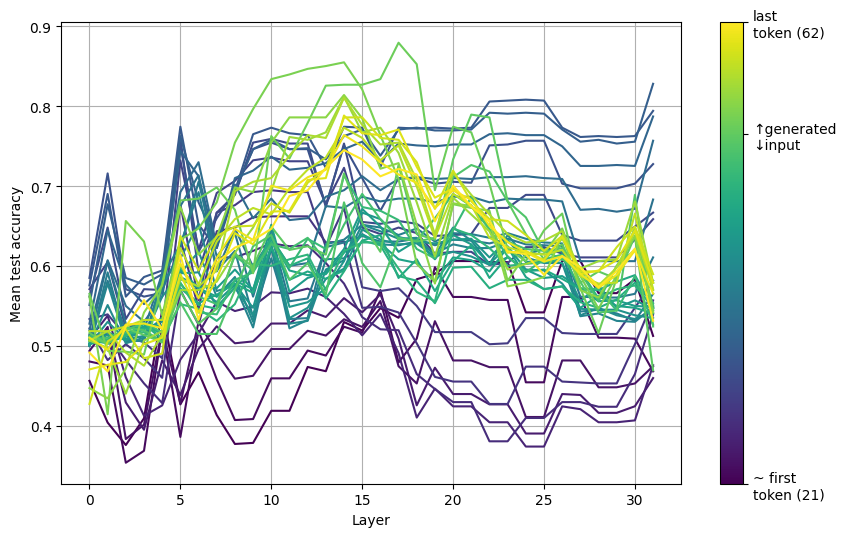

In [200]:
colors = matplotlib.cm.viridis(np.linspace(0, 1, mean_test_acc.shape[1]))  # Color map
x = range(0, num_modules)
fig, ax = plt.subplots(figsize=(10, 6))  # Define a figure and axes explicitlyx = range(0, num_modules)
for i in range(mean_test_acc.shape[1]):
    ax.plot(x, mean_test_acc[:, i], color=colors[i])

ax.grid()
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=0, vmax=mean_test_acc.shape[1]))
sm.set_array([])  # You need this line even though it's counterintuitive (sets up the ScalarMappable correctly)
cbar = fig.colorbar(sm, ax=ax, orientation='vertical')
cbar.set_ticks([0, mean_test_acc.shape[1]-10, mean_test_acc.shape[1]])  # Set ticks at the start and end
cbar.set_ticklabels([f'~ first\ntoken ({start_idx})', '\u2191generated\n\u2193input', f'last\ntoken ({end_idx})'])  # Label for each tick
# cbar.set_ticks([0, mean_test_acc.shape[1]])
# cbar.set_ticklabels([f'{start_idx}th\ntoken', 'last\nstatement\ntoken'])
# cbar.set_ticklabels([f'{start_idx}th\ntoken', f'{end_idx}th\ntoken'])

ax.set_ylabel('Mean test accuracy')
ax.set_xlabel('Layer')
plt.savefig(f"{plots_folder}/{probe_type}_mean_test_accs_train_{train_dataset['dataset_name']}_test_{test_dataset['dataset_name']}.png")
plt.show()

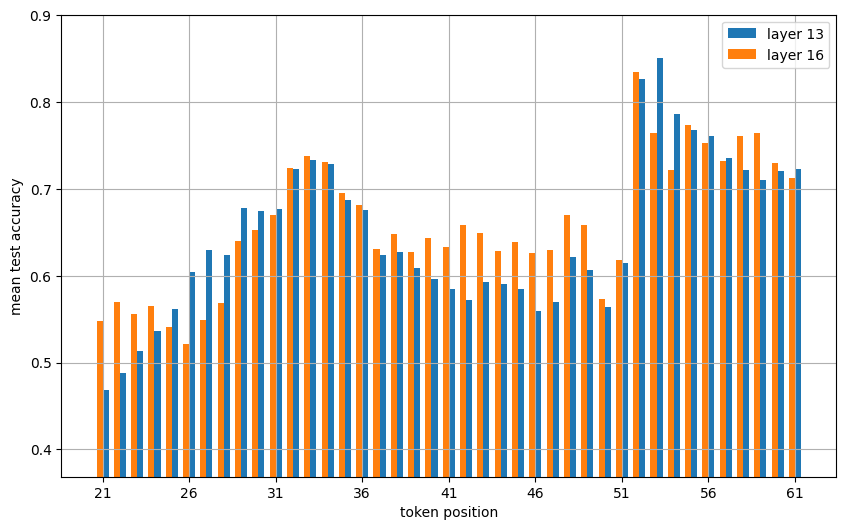

In [202]:
# make bar plot over all tokens
width = 0.35  # the width of the bars
fig, ax = plt.subplots(figsize=(10, 6))
indices = range(len(non_nans))
indices = np.array(range(start_idx, end_idx))
bars2 = ax.bar(indices + width*0.5, mean_test_acc[13], width, label='layer 13')
bars2 = ax.bar(indices-width*0.5, mean_test_acc[16], width, label='layer 16')
# bars2 = ax.bar(indices - width*2/3, mean_test_acc[27], width, label='layer 27')
# Adding labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('token position')
ax.set_ylabel('mean test accuracy')
ax.set_ylim(min(mean_test_acc[13].min(),mean_test_acc[16].min())-0.1, max(mean_test_acc[13].max(),mean_test_acc[16].max())+0.05)
ax.set_title('')
ax.set_xticks(indices[::5])
ax.set_xticklabels([str(index) for index in indices[::5]])
ax.legend()
ax.grid()
plt.savefig(f"{plots_folder}/{probe_type}_mean_test_accs_bars_train_{train_dataset['dataset_name']}_test_{test_dataset['dataset_name']}.png")

plt.show()


100%|██████████| 32/32 [00:00<00:00, 531.13it/s]


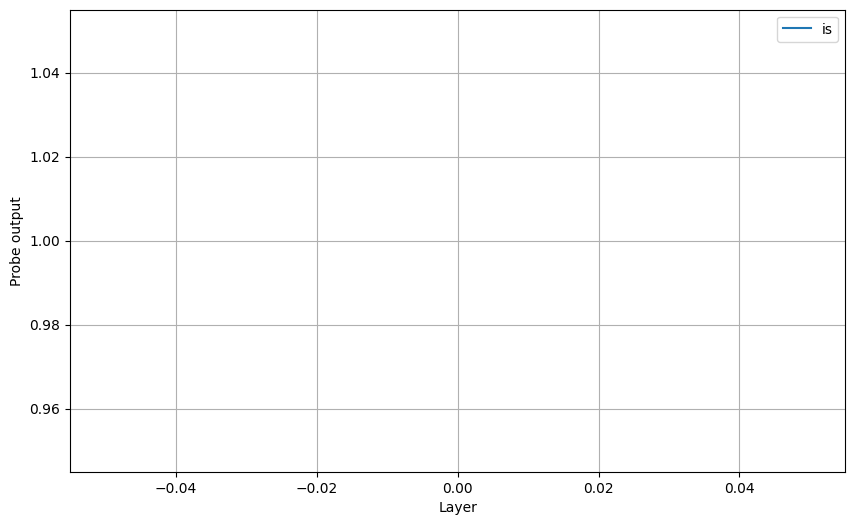

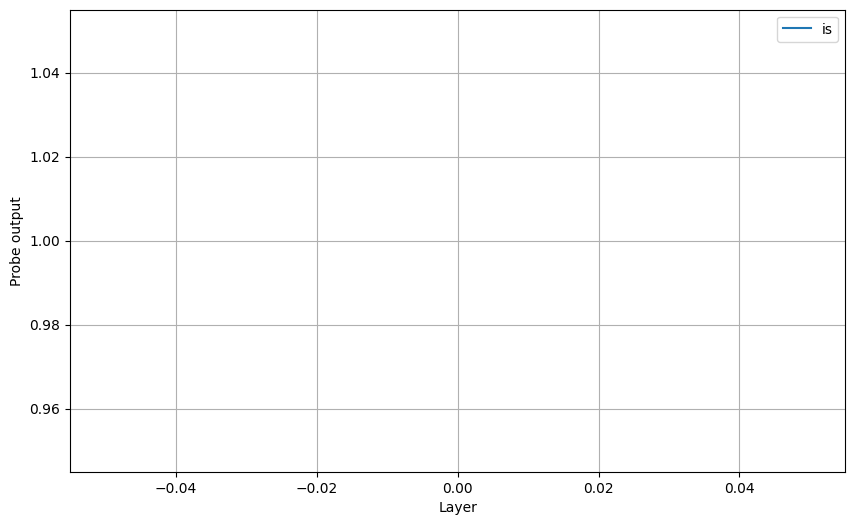

In [204]:
def plot_test_accs(test_accs, detokenized, train_dataset_name, test_dataset_name):
    # plot test accs for ood dataset
    plt.figure(figsize=(10, 6))

    for idx, label in enumerate(detokenized):
        plt.plot(test_accs[:, idx], label=label)
    plt.ylabel('Probe output')
    plt.xlabel('Layer')
    plt.grid()
    plt.legend()
    plt.savefig(f"{plots_folder}/{probe_type}_trained_{train_dataset_name}_tested_{test_dataset_name}.png")
    plt.show()



all_detokenized = []
all_test_accs = []
test_sentence = 'The capital of France is'
for format_sentence in [test_dataset['truth_format'].format(test_sentence), test_dataset['lie_format'].format(test_sentence)]:
    inputs = tokenizer(format_sentence, return_tensors="pt").to(model.device)
    decoded = []
    for idx, input_id in enumerate(inputs['input_ids'][0]):
        decoded.append(tokenizer.decode(input_id))
    all_detokenized.append(decoded)
    token_positions = range(inputs['input_ids'].shape[1])
    hidden_states = get_hidden_from_tokens(model, module_names, inputs, token_position=token_positions)

    # TODO: normalize

    hidden_states = hidden_states.to(device=device, dtype=torch.float32)
  
    test_accs_formats = torch.zeros((len(module_names), len(token_positions)))
    for idx, module in tqdm(enumerate(module_names), total=len(module_names)):
        for token_pos in token_positions:
            test_accs_formats[idx][token_pos] = probes[module].forward(hidden_states[idx,:,token_pos, :]).detach().cpu()
    all_test_accs.append(test_accs_formats)

for idx, name in enumerate(['truth_format', 'lie_format']):
    plot_test_accs(all_test_accs[idx][11:], all_detokenized[idx][11:], train_dataset['dataset_name'], name)

